In [1]:
%pwd

# Check Pytorch Version #
import torch
print(torch.__version__)

# move path for training (. = '/home/kwy00/ysy/')
%cd /home/kwy00/ysy/

!ls -l

import warnings
warnings.filterwarnings(action='ignore')

import random
import pandas as pd
import numpy as np
import os
import glob
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# import models for detection
import torchvision
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# for data augmentation and image drawing and reading
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.auto import tqdm
from torchmetrics.detection import MeanAveragePrecision

2.1.0+cu121
/home/kwy00/ysy
합계 7120
-rw-rw-r-- 1 kwy00 kwy00 2952752 Oct 13 01:33 baseline_submit.csv
-rw-rw-r-- 1 kwy00 kwy00 3618645 Oct 20 21:00 baseline_validation_version.ipynb
-rw-rw-r-- 1 kwy00 kwy00    1092 May  7 20:43 classes.txt
drwxrwxr-x 4 kwy00 kwy00    4096 Oct 18 01:03 results
-rw-rw-r-- 1 kwy00 kwy00     102 May  7 06:57 sample_submission.csv
drwxrwxr-x 2 kwy00 kwy00  135168 May  7 08:46 test
drwxrwxr-x 2 kwy00 kwy00  495616 Oct 15 21:28 train
drwxrwxr-x 2 kwy00 kwy00   69632 Oct 15 21:28 valid


In [2]:
# get cuda device if nvidia gpu is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [34]:
#####################################################
#              Training Configuration               #
##################################################### 

# define configuration setting here
# NUM_CLASSS = 34, SEED = 41 cannot be changed

CFG = {
    'NUM_CLASS':34,
    'IMG_WIDTH_SIZE':1280,
    'IMG_HEIGHT_SIZE':800,
    'EPOCHS':30, 
    'LR':1.5e-4,
    'BATCH_SIZE':8,
    'SEED':41
}



# setting seeds for random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

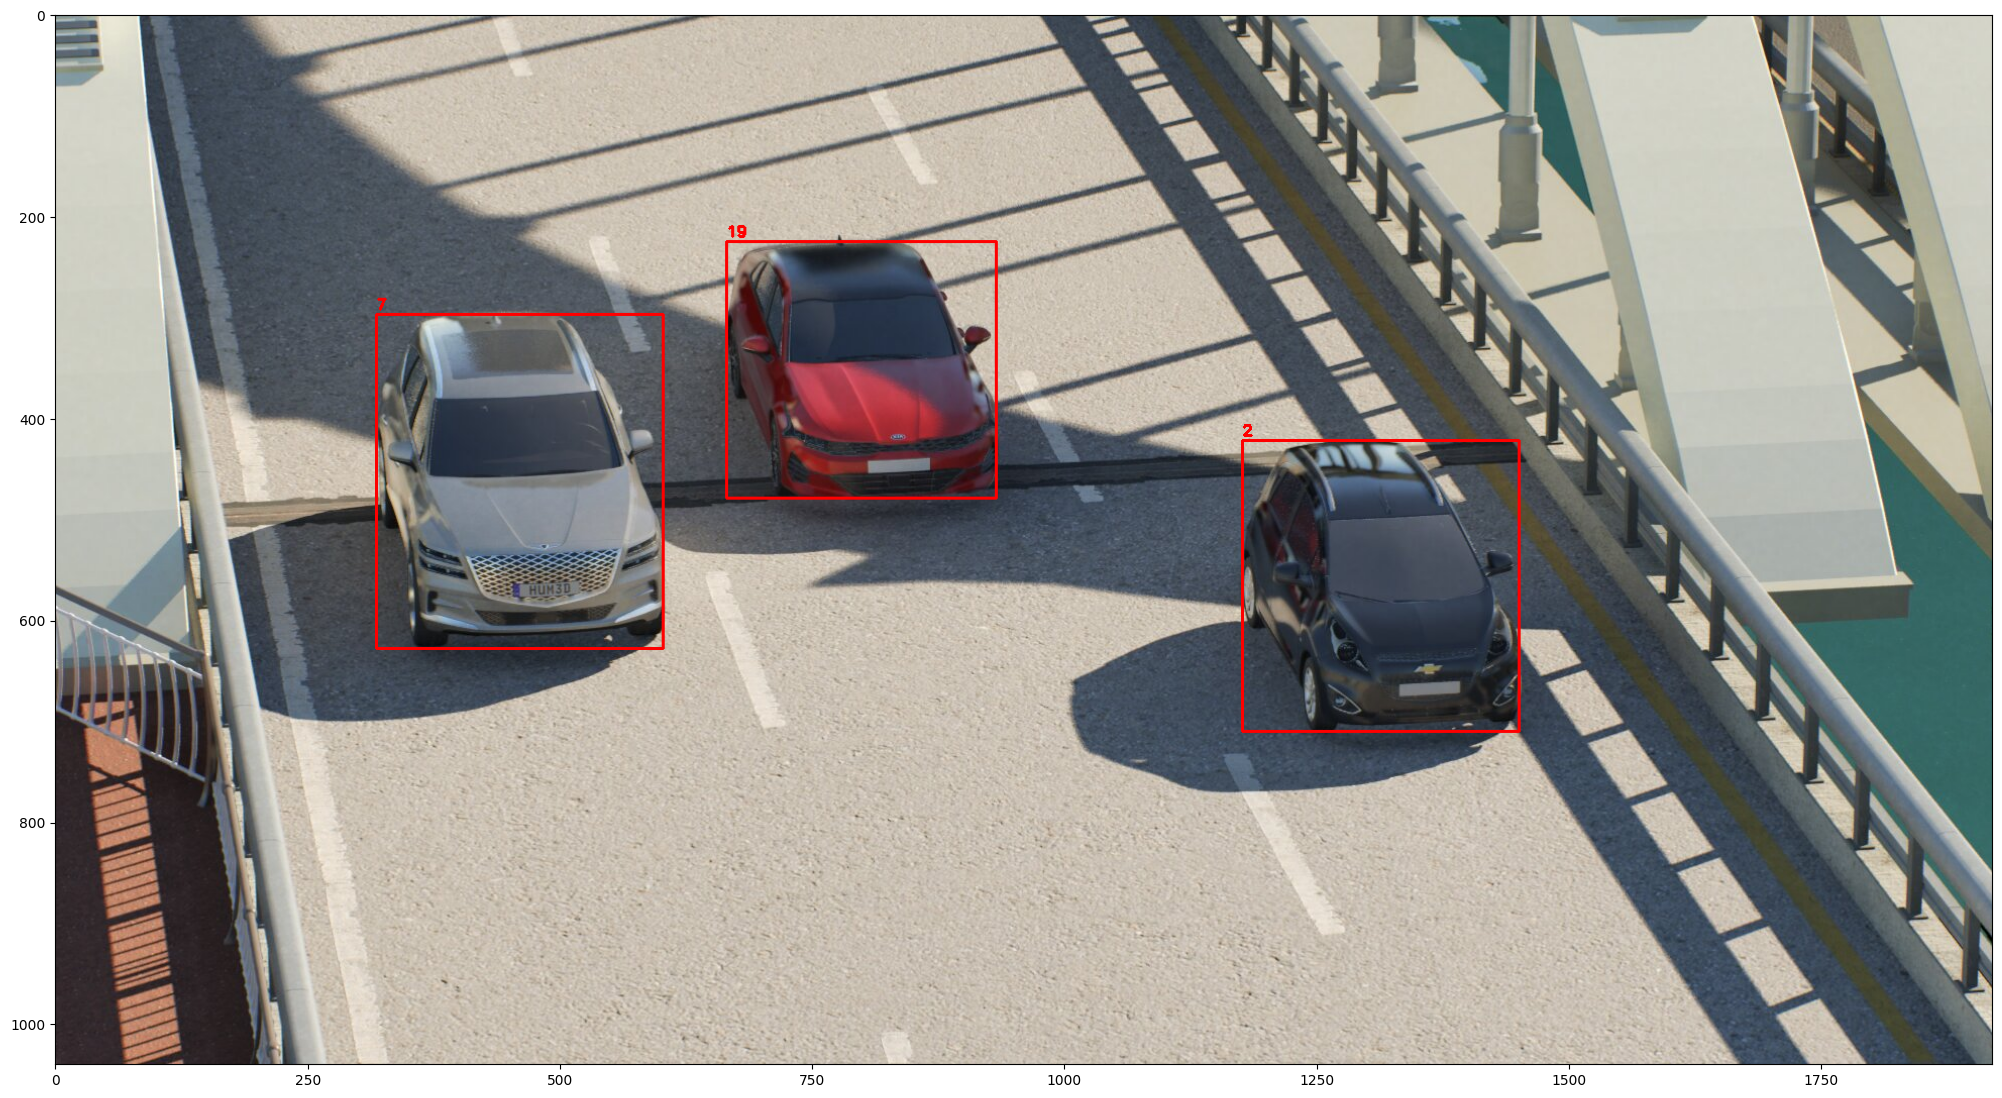

In [4]:
def draw_boxes_on_image(image_path, annotation_path):
    # 이미지 불러오기
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # txt 파일에서 Class ID와 Bounding Box 정보 읽기
    with open(annotation_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        values = list(map(float, line.strip().split(' ')))
        class_id = int(values[0])
        x_min, y_min = int(round(values[1])), int(round(values[2]))
        x_max, y_max = int(round(max(values[3], values[5], values[7]))), int(round(max(values[4], values[6], values[8])))

        # 이미지에 바운딩 박스 그리기
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        cv2.putText(image, str(class_id), (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # 이미지와 바운딩 박스 출력
    plt.figure(figsize=(25, 25))
    plt.imshow(image)
    plt.show()

# 파일 경로 설정
image_file = './train/syn_00577.png'
annotation_file = './train/syn_00577.txt'

# 함수 실행
draw_boxes_on_image(image_file, annotation_file)


In [35]:
#####################################################
#                  define dataset                   #
#####################################################

# here getting data source from hw storage.

class CustomDataset(Dataset):

    def __init__(self, root, train=True, valid=False, transforms=None):
        # root path
        self.root = root
        self.train = train
        self.valid = valid
        self.transform_args = transforms
        
        # image data
        self.imgs = sorted(glob.glob(root+'/*.png'))

        if train or valid: # both train, valid requires txt annotation.
            self.boxes = sorted(glob.glob(root+'/*.txt'))
        
            
    # only create labels for detection (class, bbox location(four edges))
    def parse_boxes(self, box_path):
        with open(box_path, 'r') as file:
            lines = file.readlines()

        boxes = []
        labels = []

        for line in lines:
            values = list(map(float, line.strip().split(' ')))
            class_id = int(values[0])
            x_min, y_min = int(round(values[1])), int(round(values[2]))
            x_max, y_max = int(round(max(values[3], values[5], values[7]))), int(round(max(values[4], values[6], values[8])))

            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(class_id)

        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)
    
    # make dataset(image, label each + transforms)
    def __getitem__(self, idx):
        
        img_path = self.imgs[idx]
        img = cv2.imread(self.imgs[idx])
        # convert image color mode (BGR -> RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.uint8)

        height, width = img.shape[0], img.shape[1]
        
        if self.train or self.valid:
            # from annotation path
            box_path = self.boxes[idx]
            boxes, labels = self.parse_boxes(box_path)
            labels += 1 # Background = 0, add background label as 0
                
            transformed = self.transform_args(image=img, bboxes=boxes, labels=labels)
            img, boxes, labels = transformed["image"], transformed["bboxes"], transformed["labels"]
            
            return img, torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)
        else:
            
            transformed = self.transform_args(image=img)
            img = transformed["image"]
            file_name = img_path.split('/')[-1]
            return file_name, img, width, height

    def __len__(self):
        return len(self.imgs)

# define function that couple train image and its label(for classification, bbox edge location)
# used for dataloader collate function
def collate_fn(batch):
    images, targets_boxes, targets_labels = tuple(zip(*batch))
    # stacking 2D image for total 3D (batch_size, image_width, image_height, image_features)
    images = torch.stack(images, 0)
    targets = []

    for i in range(len(targets_boxes)):
        target = {
            "boxes": targets_boxes[i],
            "labels": targets_labels[i]
        }
        
        targets.append(target)

    return images, targets


In [36]:
class CustomDatasetV2(Dataset): # used for nearbbox_cropping augmentation

    def __init__(self, root, transforms=None):

        self.root = root
        self.transform_args = transforms
        
        self.imgs = sorted(glob.glob(root+'/*.png'))
        self.boxes = sorted(glob.glob(root+'/*.txt'))
        
    def parse_boxes(self, box_path):
        with open(box_path, 'r') as file:
            lines = file.readlines()

        boxes = []
        labels = []

        for line in lines:
            values = list(map(float, line.strip().split(' ')))
            class_id = int(values[0])
            x_min, y_min = int(round(values[1])), int(round(values[2]))
            x_max, y_max = int(round(max(values[3], values[5], values[7]))), int(round(max(values[4], values[6], values[8])))

            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(class_id)

        return boxes, torch.tensor(labels, dtype=torch.int64)
    
    def __getitem__(self, idx):
        
        img_path = self.imgs[idx]
        
        img = cv2.imread(self.imgs[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.uint8)
        
        height, width = img.shape[0], img.shape[1]
        box_path = self.boxes[idx]
        boxes, labels = self.parse_boxes(box_path)
        labels += 1 
        
        box_index = idx%len(boxes)    
        transformed = self.transform_args(image=img, bboxes=boxes, labels=labels, cropping_bbox=[boxes[box_index][0], boxes[box_index][1], boxes[box_index][2], boxes[box_index][3]])
        img, boxes, labels = transformed["image"], transformed["bboxes"], transformed["labels"]
        
        if len(boxes) == 0: # if there is no boxes because of cropping(consider min_visibility, min_area)
            labels = torch.tensor([0])
            return img, torch.tensor(labels, dtype=torch.int64)
            
        
        return img, torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)
        
    def __len__(self):
        return len(self.imgs)


# def collate_fn_v2(batch):
    
#     if (len(tuple(zip(*batch))) == 2):
#         images, targets_labels = tuple(zip(*batch))
#         images = torch.stack(images, 0)
#         targets = []
        
#         for i in range(len(targets_labels)):
#             target = {
#                 "labels": targets_labels[i]
#             }
#             targets.append(target)
#     else:    
#         images, targets_boxes, targets_labels = tuple(zip(*batch))
#         images = torch.stack(images, 0)
#         targets = []

#         for i in range(len(targets_boxes)):
#             target = {
#                 "boxes": targets_boxes[i],
#                 "labels": targets_labels[i]
#             }
            
#             targets.append(target)

#     return images, targets


In [44]:
###################################################
#               define augmentation               #
###################################################

# define data transformation(augmentation) here!
# used for CustomDataset transforms args
# if you want to augment data amount, you need to define transformation method indivisually (A.Compose()!)

# reference : https://albumentations.ai/docs/api_reference/augmentations/transforms/

def default_train_transforms():
    return A.Compose([
        A.augmentations.geometric.transforms.HorizontalFlip(p=0.2), # 20% image will be fliped..
        A.augmentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE']), # baseline resize to (512 x 512)    
        ToTensorV2(), # albumentations pytorch transforms ToTensorV2()
        
        # bounding box format: pascal_voc, label_fields: 'labels'
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    

def horizontalflip_transforms():
    return A.Compose([
        A.augmentations.geometric.transforms.HorizontalFlip(p=1.0),
        A.augmentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE']), # baseline resize to (512 x 512)    
        ToTensorV2(), # albumentations pytorch transforms ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def pixeldrop_transforms():
        
    return A.Compose([
        A.augmentations.transforms.PixelDropout(dropout_prob=0.5, drop_value=0, p=1.0),
        A.augmentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE']),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def colorjitter_transforms():
    return A.Compose([
        A.augmentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE']),
        A.augmentations.transforms.ColorJitter(brightness=(0.5, 1.2), contrast=(0.5, 1.2),
                                               saturation=(0.5, 1.2), hue=0.0,
                                               always_apply=False, p=1.0),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def bboxsafe_cropping_transforms():    
    return A.Compose([
            A.augmentations.crops.transforms.BBoxSafeRandomCrop(p=1.0),
            A.augmentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.Resize(CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE']),
            ToTensorV2(),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'],
                                    min_area=36000, min_visibility=0.2))
    
def bboxsafe_cropping_transforms_v2():    
    return A.Compose([
            A.augmentations.crops.transforms.BBoxSafeRandomCrop(p=1.0),
            A.augmentations.transforms.PixelDropout(dropout_prob=0.5, drop_value=0, p=0.5),
            A.augmentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.Resize(CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE']),
            ToTensorV2(),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'],
                                    min_area=36000, min_visibility=0.2))
    

def bbox_nearcrop_transforms():
    return A.Compose([
            A.augmentations.crops.transforms.RandomCropNearBBox(max_part_shift=(0.0, 0.0), p=1.0),
            A.augmentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.Resize(CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE']),
            ToTensorV2(),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    
def bbox_nearcrop_transforms_v2():
    return A.Compose([
            A.augmentations.crops.transforms.RandomCropNearBBox(max_part_shift=(0.0, 0.0), p=1.0),
            A.augmentations.dropout.cutout.Cutout(num_holes=3, max_h_size=80, max_w_size=40, p=1.0),
            A.augmentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            A.Resize(CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE']),
            ToTensorV2(),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    

def scaling_noise_transforms():
    scale_ratio = 0.25 # for better effect on decreasing quality
        
    return A.Compose([
        A.augmentations.transforms.Downscale(scale_min=scale_ratio, scale_max=scale_ratio, p=1.0),
        A.augmentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE']),
        # A.augmentations.transforms.GaussNoise(p=1.0), # for more dirty image quality...
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_valid_transforms():
    return A.Compose([
        A.augmentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE']),
        ToTensorV2(), 
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    
    

def get_test_transforms():
    return A.Compose([
        A.augmentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.Resize(CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE']),
        ToTensorV2(),
    ])



In [9]:
###################################################################
#                        define model                             #
###################################################################

# try different model as we need to experiment various model and compare the result. 

# def build_model(num_classes=CFG['NUM_CLASS']+1): # NUM_CLASS + 1 for background label
#     model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True) # default resnet50 backbone faster rcnn
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
#     return model


def build_model():
    model = torchvision.models.detection.retinanet_resnet50_fpn_v2(pretrained=True, pretrained_backbone=True)
    return model

model = build_model()
model

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [18]:
################################################
#              define utils tools              #
################################################

#defined here, util function for saving model and plotting

from itertools import product
import logging
import random
import pickle
import shutil
import json
import yaml
import csv
import os

'''
File IO
'''

def save_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
    
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def save_json(path, obj, sort_keys=True)-> str:  
    try:
        with open(path, 'w') as f:    
            json.dump(obj, f, indent=4, sort_keys=sort_keys)
        msg = f"Json saved {path}"
    except Exception as e:
        msg = f"Fail to save {e}"
    return msg

def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)
    
'''
Logger
'''
def get_logger(name: str, dir_: str, stream=False) -> logging.RootLogger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    
    formatter = logging.Formatter('%(asctime)s | %(name)s | %(levelname)s | %(message)s')
    stream_handler = logging.StreamHandler()
    file_handler = logging.FileHandler(os.path.join(dir_, f'{name}.log'))
    
    stream_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)
    
    if stream:
        logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    return logger

###########################################
#            define recorder              #
###########################################

import os
import sys

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import logging
import torch
import csv

class Recorder():
    def __init__(self,
                record_dir:str,
                model: object,
                optimizer: object,
                scheduler: object,
                amp: object,
                logger: logging.RootLogger=None):
        
        self.record_dir = record_dir
        self.plot_dir = os.path.join(record_dir, 'plots')
        self.record_filepath = os.path.join(self.record_dir, 'record.csv')
        self.weight_path = os.path.join(record_dir, 'model.pt')
        
        self.logger = logger
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.amp = amp
        
        os.makedirs(self.plot_dir, exist_ok = True)
        
    def set_model(self, model: 'model'):
        self.model = model
        
    def set_logger(self, logger: logging.RootLogger):
        self.logger = logger
        
    def create_record_directory(self):
        os.makedirs(self.record_dir, exist_ok=True)
        
        msg = f"Create directory {self.record_dir}"
        self.logger.info(msg) if self.logger else None
        
    def add_row(self, row_dict: dict):
        fieldnames = list(row_dict.keys())
        
        with open(self.record_filepath, newline='', mode='a') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            
            if f.tell() == 0:
                writer.writeheader()
                
            writer.writerow(row_dict)
            msg = f"Write row {row_dict['epoch_index']}"
            self.logger.info(msg) if self.logger else None
            
    def save_weight(self, epoch:int) -> None:
        if self.amp is not None:
            check_point = {
                'epoch': epoch+1,
                'model': self.model.state_dict(),
                'optimizer': self.optimizer.state_dict(),
                'scheduler': self.scheduler.state_dict() if self.scheduler else None,
                'amp': self.amp.state_dict()
            }
        else:
            check_point = {
                'epoch': epoch + 1,
                'model': self.model.state_dict(),
                'optimizer': self.optimizer.state_dict(),
                'scheduler': self.scheduler.state_dict() if self.scheduler else None,
            }
        torch.save(check_point, self.weight_path)
        msg = f"Recorder, epoch {epoch} Model saved: {self.weight_path}"
        self.logger.info(msg) if self.logger else None
        
    def save_plot(self, plots: list):
        

        record_df = pd.read_csv(self.record_filepath)
        current_epoch = record_df['epoch_index'].max()
        epoch_range = list(range(0, current_epoch+1))
        color_list = ['red', 'blue']  # train, val

        for plot_name in plots:
            columns = [f'train_{plot_name}', f'val_{plot_name}']
            
            fig = plt.figure(figsize=(20, 8))
            
            for id_, column in enumerate(columns):
                values = record_df[column].tolist()
                plt.plot(epoch_range, values, marker='.', c=color_list[id_], label=column)
             
            plt.title(plot_name, fontsize=15)
            plt.legend(loc='upper right')
            plt.grid()
            plt.xlabel('epoch')
            plt.ylabel(plot_name)
            plt.xticks(epoch_range, [str(i) for i in epoch_range])
            plt.close(fig)
            fig.savefig(os.path.join(self.plot_dir, plot_name +'.png'))


##############################################
#            define earlystopper             #
##############################################

import numpy as np
import logging

class EarlyStopper():
    
    def __init__(self, patience: int, mode: str, logger: logging.RootLogger=None) -> None:
        self.patience = patience
        self.mode = mode
        self.logger = logger
        
        # Initiate
        self.patience_counter = 0
        self.stop = False
        self.best_loss = np.inf
        
        msg = f'Initiated early stopper, mode: {self.mode}, best score: {self.best_loss}, patience: {self.patience}'
        self.logger.info(msg) if self.logger else None
        
    def check_early_stopping(self, loss: float) -> None:
        loss = -loss if self.mode == 'max' else loss
        
        if loss > self.best_loss:
            # Higher loss (worse score)
            self.patience_counter += 1
            
            msg = f"Early stopper, counter {self.patience_counter}/{self.patience}, best:{abs(self.best_loss)} -> now:{abs(loss)}"
            self.logger.info(msg) if self.logger else None
            
        elif loss <= self.best_loss:
            # Lower loss (better score)
            self.patience_counter = 0
            self.best_loss = loss
            
            if self.logger is not None:
                msg = f"Early stopper, counter {self.patience_counter}/{self.patience}, best:{abs(self.best_loss)} -> now:{abs(loss)}"
                self.logger.info(msg)
                self.logger.info(f"Set counter as {self.patience_counter}")
                self.logger.info(f"Update best score as {abs(loss)}")
        
        else:
            print('debug')
 


In [39]:
#################################################
#              define training loop             #
#################################################


from datetime import datetime, timezone, timedelta
from time import time
import copy

def train(model, train_loader, valid_loader, optimizer, 
          scheduler, early_stopper, train_serial,
          logger, recorder, device, interval=100):
    
    EPOCHS = CFG['EPOCHS'] # training epoch
    model.to(device) # allocate model to gpu memory

    for epoch in range(0, CFG['EPOCHS']):
        
        print("current lr: ", optimizer.param_groups[0]['lr'])
        
        # For Recording..
        row_dict = dict()
        row_dict['epoch_index'] = epoch
        row_dict['train_serial'] = train_serial
        
        """
        Train start
        """
        print(f"Train {epoch}/{EPOCHS}")
        logger.info(f"--Train {epoch}/{EPOCHS}")
        
        # start time recording
        start_timestamp = time()
        
        model.train()
        train_loss = []
        train_map_arr = []
        train_map_50 = []
        train_map_75 = []
        
        # data batch processing
        for batch_index, (images, targets) in enumerate(tqdm(train_loader)):
            model.train()
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            losses.backward()
            optimizer.step()

            train_loss.append(losses.item())
            
            if batch_index % interval == 0:
                msg = f"batch: {batch_index}/{len(train_loader)} loss: {losses.item()}"
                logger.info(msg)
            
            model.eval()
            with torch.no_grad():
                prediction = model(images)
                
            # metrics for Mean Average Precision
            metric = MeanAveragePrecision(iou_type='bbox')
            metric.update(prediction, targets)
            map_dict = metric.compute()
            
            train_map_arr.append(map_dict['map'])
            train_map_50.append(map_dict['map_50'])
            train_map_75.append(map_dict['map_75'])
            
        tr_map = np.mean(train_map_arr)
        tr_map_50 = np.mean(train_map_50)
        tr_map_75 = np.mean(train_map_75)
        tr_loss = np.mean(train_loss)
        end_timestamp = time()
        
        row_dict['train_loss'] = tr_loss
        row_dict['train_elapsed_time'] = end_timestamp - start_timestamp
        row_dict['train_map'] = tr_map
        row_dict['train_map_50'] = tr_map_50
        row_dict['train_map_75'] = tr_map_75
        
        print(f'Epoch [{epoch}] Train loss : [{tr_loss:.5f}]')
        print(f'Epoch [{epoch}] Train map : [{tr_map:.5f}]')
        print(f'Epoch [{epoch}] Train_50 map : [{tr_map_50:.5f}]')
        print(f'Epoch [{epoch}] Train_75 map : [{tr_map_75:.5f}]')
        
            
        """
        Validation Start
        """
        print(f"Validation {epoch}/{EPOCHS}")
        logger.info(f"--Val {epoch}/{EPOCHS}")
        
        # start time recording
        start_timestamp = time()
        
        model.eval()
        val_loss = []
        val_map_arr = []
        val_map_50 = []
        val_map_75 = []
        
        for batch_index ,(images, targets) in enumerate(tqdm(valid_loader)):
            model.eval()
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # model returns List[dict[Tensor]], one for each input image, 
            # list -> Dict -> boxes, labels, scores 
            # model inference (no gradient update)
            with torch.no_grad():
                prediction = model(images)
            
            # metrics for Mean Average Precision
            metric = MeanAveragePrecision(iou_type='bbox')
            metric.update(prediction, targets)
            map_dict = metric.compute()
            
            val_map_arr.append(map_dict['map'])
            val_map_50.append(map_dict['map_50'])
            val_map_75.append(map_dict['map_75'])
            
            model.train()
            with torch.no_grad():
                val_loss_dict = model(images, targets)
            val_losses = sum(loss for loss in val_loss_dict.values())
            val_loss.append(val_losses.item())
            
            if batch_index % interval == 0:
                msg = f"batch: {batch_index}/{len(valid_loader)} loss: {val_losses.item()}"
                logger.info(msg)
            

        end_timestamp = time()        
        vl_loss = np.mean(val_loss)
        vl_map = np.mean(val_map_arr)
        vl_map_50 = np.mean(val_map_50)
        vl_map_75 = np.mean(val_map_75)

        row_dict['val_loss'] = vl_loss
        row_dict['val_elapsed_time'] = end_timestamp - start_timestamp
        row_dict['val_map'] = vl_map
        row_dict['val_map_50'] = vl_map_50
        row_dict['val_map_75'] = vl_map_75
        
        print(f'Epoch [{epoch}] Valid loss : [{vl_loss:.5f}]')
        print(f'Epoch [{epoch}] valid map : [{vl_map:.5f}]')
        print(f'Epoch [{epoch}] valid_50 map : [{vl_map_50:.5f}]')
        print(f'Epoch [{epoch}] valid_75 map : [{vl_map_75:.5f}]')
        
        """
        Recorder
        """
        
        # plot naming rule : train_{plot_name} should be same as row_dict key
        recorder.add_row(row_dict)
        recorder.save_plot(['loss', 'elapsed_time', 'map', 'map_50', 'map_75'])

        if scheduler is not None:
            scheduler.step()
        
        # early_stopping_target = 'val_loss'
        # early_stopper.check_early_stopping(loss=row_dict[early_stopping_target])
        
        # if (early_stopper.patience_counter == 0) or (epoch == EPOCHS-1):
        #     recorder.save_weight(epoch=epoch)
        #     best_row_dict = copy.deepcopy(row_dict)
        
        # if early_stopper.stop == True:
        #     logger.info(f"Early stopped, counter {early_stopper.patience_counter}/{early_stopper.patience}")
    
    # save final model only(early stopping is not completed code..)
    recorder.save_weight(epoch=epoch)
    

In [45]:
from datetime import datetime, timezone, timedelta


# root directory
ROOT_DIR = '/home/kwy00/ysy/'

# define train serial
kst = timezone(timedelta(hours=9))
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")

# recorder directory
RECORDER_DIR = os.path.join(ROOT_DIR, 'results', 'train', train_serial)
os.makedirs(RECORDER_DIR, exist_ok=True)

# set logger
logger = get_logger(name='train', dir_=RECORDER_DIR, stream=False)
logger.info(f"Set Logger {RECORDER_DIR}")


# dataset instance (transformed dataset for train, valid, test)
# if you want to use train data only, simply use ConCatDataset(train, valid)
basic_train_dataset = CustomDataset('./train', train=True, valid=False, transforms=default_train_transforms())
colorjitter_train_dataset = CustomDataset('./train', train=True, valid=False, transforms=colorjitter_transforms())
pixeldrop__train_dataset = CustomDataset('./train', train=True, valid=False, transforms=pixeldrop_transforms())
bboxsafe_cropping_train_dataset = CustomDatasetV2('./train', transforms=bboxsafe_cropping_transforms_v2())
bbox_nearcropping_train_dataset = CustomDatasetV2('./train', transforms=bbox_nearcrop_transforms_v2())


train_dataset = ConcatDataset([basic_train_dataset, colorjitter_train_dataset,
                               bbox_nearcropping_train_dataset,
                               pixeldrop__train_dataset,
                               bboxsafe_cropping_train_dataset])
valid_dataset = CustomDataset('./valid', train=False, valid=True, transforms=get_valid_transforms())
test_dataset = CustomDataset('./test', train=False, valid=False, transforms=get_test_transforms())

# create dataloader with batch_size=, shuffle=,
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, collate_fn=collate_fn) # collate_fn used here!
valid_loader = DataLoader(valid_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False)

logger.info(f"Load data, train:{len(train_dataset)} val:{len(valid_dataset)}")

# earlystopping (change mode to 'min')
early_stopper = EarlyStopper(patience=10, mode='min', logger=logger)

# define model
model = build_model()

# define optimizer and scheduler
# optimizer = torch.optim.Adam(model.parameters(), lr=CFG['LR'])
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG['LR'])
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

recorder = Recorder(record_dir=RECORDER_DIR, 
                    model = model,
                    optimizer=optimizer,
                    scheduler=None,
                    amp= None,
                    logger=logger)



train(model, train_loader, valid_loader, 
                    optimizer, scheduler, early_stopper,
                    train_serial, logger, recorder, device)

current lr:  0.00015
Train 0/30


 42%|████▏     | 1451/3426 [38:21<52:41,  1.60s/it]  

In [27]:
def box_denormalize(x1, y1, x2, y2, width, height):
    x1 = (x1 / CFG['IMG_WIDTH_SIZE']) * width
    y1 = (y1 / CFG['IMG_HEIGHT_SIZE']) * height
    x2 = (x2 / CFG['IMG_WIDTH_SIZE']) * width
    y2 = (y2 / CFG['IMG_HEIGHT_SIZE']) * height
    return x1.item(), y1.item(), x2.item(), y2.item()


predict_timestamp = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")
predict_serial = train_serial + '_' + predict_timestamp

PREDICT_DIR = os.path.join('/home/kwy00/ysy/', 'results', 'predict', predict_serial)
os.makedirs(PREDICT_DIR, exist_ok=True)


def inference(test_loader, device):
    
    model = build_model()
    model.to(device)
    
    checkpoint = torch.load(os.path.join(RECORDER_DIR, 'model.pt'))
    model.load_state_dict(checkpoint['model'])
    
    model.eval()
    results = pd.read_csv('./sample_submission.csv')

    for img_files, images, img_width, img_height in tqdm(iter(test_loader)):
        images = [img.to(device) for img in images]

        with torch.no_grad():
            outputs = model(images)

        for idx, output in enumerate(outputs):
            boxes = output["boxes"].cpu().numpy()
            labels = output["labels"].cpu().numpy()
            scores = output["scores"].cpu().numpy()

            for box, label, score in zip(boxes, labels, scores):
                x1, y1, x2, y2 = box
                x1, y1, x2, y2 = box_denormalize(x1, y1, x2, y2, img_width[idx], img_height[idx])
                
                index_list = list([1])
                new_row = pd.DataFrame({"file_name": img_files[idx],
                                    "class_id": label-1,
                                    "confidence": score,
                                    "point1_x":x1, "point1_y":y1,
                                    "point2_x":x2, "point2_y":y1,
                                    "point3_x":x2, "point3_y":y2,
                                    "point4_x":x1, "point4_y":y2},
                                       index=index_list)
                
                results = pd.concat([results, new_row], ignore_index=True)
                
                
    
    
    resultpath = os.path.join(PREDICT_DIR, 'baseline_submit.csv')
    # 결과를 CSV 파일로 저장
    results.to_csv(resultpath, index=False)
    
    print('Done.')


In [28]:
inference(test_loader, device)

100%|██████████| 425/425 [05:26<00:00,  1.30it/s]


Done.
